In [1]:

import os
import cv2

def movie_maker(image_folder, video_name):
    images = [img for img in os.listdir(image_folder) if img.endswith(".tif")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 5, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

# Get all folders in train/
names = os.listdir("train")
for i, name in enumerate(names):
    if name == "kidney_3_dense":
        continue
    image_folder = f'train/{name}/images'
    images = [img for img in os.listdir(image_folder) if img.endswith(".tif")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    print(f"{name}: {frame.shape}")


kidney_1_dense: (1303, 912, 3)
kidney_1_voi: (1928, 1928, 3)
kidney_2: (1041, 1511, 3)
kidney_3_sparse: (1706, 1510, 3)


Code below is from: https://www.kaggle.com/code/aniketkolte04/sennet-hoa-seg-pytorch-attention-gated-unet/notebook

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
import torch.nn as nn
import albumentations as A
import numpy as np
import os
import time
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [3]:
image_folder = f'train/kidney_2/images/'
image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".tif")]
image_files.sort()
labels_folder = f'train/kidney_2/labels/'
label_files = [os.path.join(labels_folder, img) for img in os.listdir(labels_folder) if img.endswith(".tif")]
label_files.sort()

In [4]:
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None],[1,1,3])
    img = img.astype('float32')
    mx = np.max(img)
    if mx:
        img/=mx
    img = np.transpose(img,(2,0,1))
    img_ten = torch.tensor(img)
    return img_ten

In [5]:
def preprocess_mask(path):
    
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    msk_ten = torch.tensor(msk)
    
    return msk_ten

In [6]:
class CustomDataset(Dataset):
    def __init__(self,image_files, mask_files, input_size=(256, 256), augmentation_transforms=None):
        self.image_files=image_files
        self.mask_files=mask_files
        self.input_size=input_size
        self.augmentation_transforms=augmentation_transforms
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self,idx):
        image_path=self.image_files[idx]
        mask_path=self.mask_files[idx]
        
        image = preprocess_image(image_path)
        mask = preprocess_mask(mask_path)
        if self.augmentation_transforms:
            image,mask=self.augmentation_transforms(image,mask)
        return image,mask

In [7]:
def augment_image(image, mask):
    
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    transform = A.Compose([
        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),
        A.RandomBrightness(p=1),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    
    ])
    augmented = transform(image = image_np,mask = mask_np)
    augmented_image , augmented_mask = augmented['image'],augmented['mask']
    
    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)
    augmented_mask  = torch.tensor(augmented_mask,dtype=torch.float32)
    
    return augmented_image,augmented_mask

In [8]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    image_files, label_files, test_size=0.1, random_state=42)

In [9]:
train_dataset = CustomDataset(train_image_files, train_mask_files, augmentation_transforms=augment_image)
val_dataset = CustomDataset(val_image_files, val_mask_files, augmentation_transforms=augment_image)

In [10]:
train_dataloader= DataLoader(train_dataset,batch_size=28,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=28,shuffle=False)

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

In [12]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.conv(x)
        return x
    

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x
    
class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):

        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) 
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

In [13]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [14]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

In [15]:
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [16]:
def train_and_test(model,dataloaders,optimizer,criterion,num_epochs=100, show_images=False):
    since = time.time()
    best_loss=1e10
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    fieldnames = ['epoch', 'training_loss', 'test_loss', 'train_dice_coeff', 'val_dice_coeff']
    train_epoch_losses = []
    val_epoch_losses = []
    for epoch in range(1,num_epochs+1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)
        batchsummary = {a: [0] for a in fieldnames}
        batch_train_loss= 0.0
        batch_test_loss = 0.0
        
        for phase in ['train','val']:
            if phase =='train':
                model.train()
            else:
                model.eval()
            for sample in iter(dataloaders[phase]):

                inputs = sample[0].to(device)
                masks = sample[1].to(device)
                
                masks = masks.unsqueeze(1)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = criterion(outputs, masks)

                    y_pred = outputs.data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()

                    batchsummary[f'{phase}_dice_coeff'].append(dice_coeff(y_pred, y_true))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        batch_train_loss += loss.item() * sample[0].size(0)

                    else:
                        batch_test_loss += loss.item() * sample[0].size(0)

            if phase == 'train':
                epoch_train_loss = batch_train_loss / len(dataloaders['train'])
                train_epoch_losses.append(epoch_train_loss)
            else:
                epoch_test_loss = batch_test_loss / len(dataloaders['val'])
                val_epoch_losses.append(epoch_test_loss)

            batchsummary['epoch'] = epoch
            
            print('{} Loss: {:.4f}'.format(phase, loss))

        best_loss = np.max(batchsummary['val_dice_coeff'])
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(
            f'\t\t\t train_dice_coeff: {batchsummary["train_dice_coeff"]}, val_dice_coeff: {batchsummary["val_dice_coeff"]}')

    print('Best dice coefficient: {:4f}'.format(best_loss))

    return model, train_epoch_losses, val_epoch_losses

In [17]:
epochs = 25
def train():
    model = AttentionUNet()
    model.load_state_dict(torch.load('custom_trained.pth'))
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e5)
    criterion = DiceLoss()
    trained_model, train_epoch_losses, test_epoch_losses = train_and_test(model, dataloaders,optimizer, criterion, num_epochs= epochs)
    return trained_model, train_epoch_losses, test_epoch_losses


trained_model, train_epoch_losses, test_epoch_losses = train()
torch.save(trained_model.state_dict(), 'custom_trained.pth')

Epoch 1/25
----------


/usr/local/lib/python3.11/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


train Loss: 0.9854
val Loss: 0.9935
			 train_dice_coeff: 0.00017786796715250496, val_dice_coeff: 0.0
Epoch 2/25
----------
train Loss: 0.9917
val Loss: 0.9936
			 train_dice_coeff: 0.0, val_dice_coeff: 0.0
Epoch 3/25
----------
train Loss: 0.9941
val Loss: 0.9933
			 train_dice_coeff: 0.0, val_dice_coeff: 0.0
Epoch 4/25
----------
train Loss: 0.9945
val Loss: 0.9938
			 train_dice_coeff: 0.0, val_dice_coeff: 0.0
Epoch 5/25
----------
train Loss: 0.9872
val Loss: 0.9932
			 train_dice_coeff: 0.0, val_dice_coeff: 0.0
Epoch 6/25
----------
train Loss: 0.9987
val Loss: 0.9912
			 train_dice_coeff: 0.0, val_dice_coeff: 0.0
Epoch 7/25
----------
train Loss: 0.9950
val Loss: 0.9950
			 train_dice_coeff: 0.0, val_dice_coeff: 0.0
Epoch 8/25
----------
train Loss: 0.9892
val Loss: 0.9913
			 train_dice_coeff: 0.0, val_dice_coeff: 0.0
Epoch 9/25
----------
train Loss: 0.9919
val Loss: 0.9932
			 train_dice_coeff: 0.0, val_dice_coeff: 0.0
Epoch 10/25
----------
train Loss: 0.9899
val Loss: 0.9926

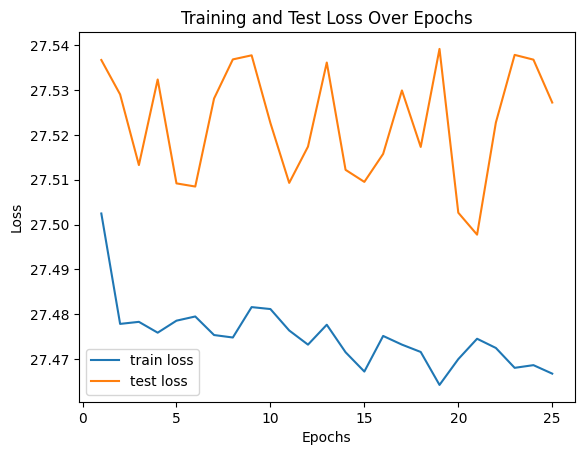

In [18]:
train_plot, = plt.plot(range(1, len(train_epoch_losses) + 1), train_epoch_losses, label='train loss')
test_plot, = plt.plot(range(1, len(test_epoch_losses) + 1), test_epoch_losses, label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.show() 